In [2]:
from time import time
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
from matplotlib import style

import pickle

style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
df = pd.read_csv('/Users/fempter/Documents/timeseries.csv')

df_copy = df

df.index = pd.to_datetime(df.Date)
df = df.drop(columns=['Date', 'DateIdx', 'Day', 'Holiday'])
df = df.rename(columns={'dewpti': 'dew_point', 'hum': 'humidity', 'pressurei': 'pressure', 'tempi': 'temperature'})

print(df.columns)

Index(['VAR', 'dew_point', 'humidity', 'pressure', 'rain', 'temperature',
       'thunder', 'PCA_1'],
      dtype='object')


In [4]:
df = df.drop(columns=['PCA_1', 'thunder', 'rain', 'PCA_1'])

forecast_dates = df.loc['2017-04-24':].iloc[:96].index
forecast_input = df.loc['2017-04-24':].iloc[:96].drop(columns=['VAR'])
forecast_input_scale = preprocessing.scale(forecast_input)

df_unknown = df.loc['2017-04-22':'2017-04-23'].copy()

df_unknown_known = df.loc['2017-04-22':'2017-04-23'].copy()

df_old = df.loc['2017-04-14':'2017-04-23'].copy()

df_whole = df.loc['2017-04-12':'2017-04-23'].copy()

df = df.loc['2017-04-12':'2017-04-21'].copy()

SpearmanrResult(correlation=-0.1120275482270283, pvalue=0.0005061579477773169)


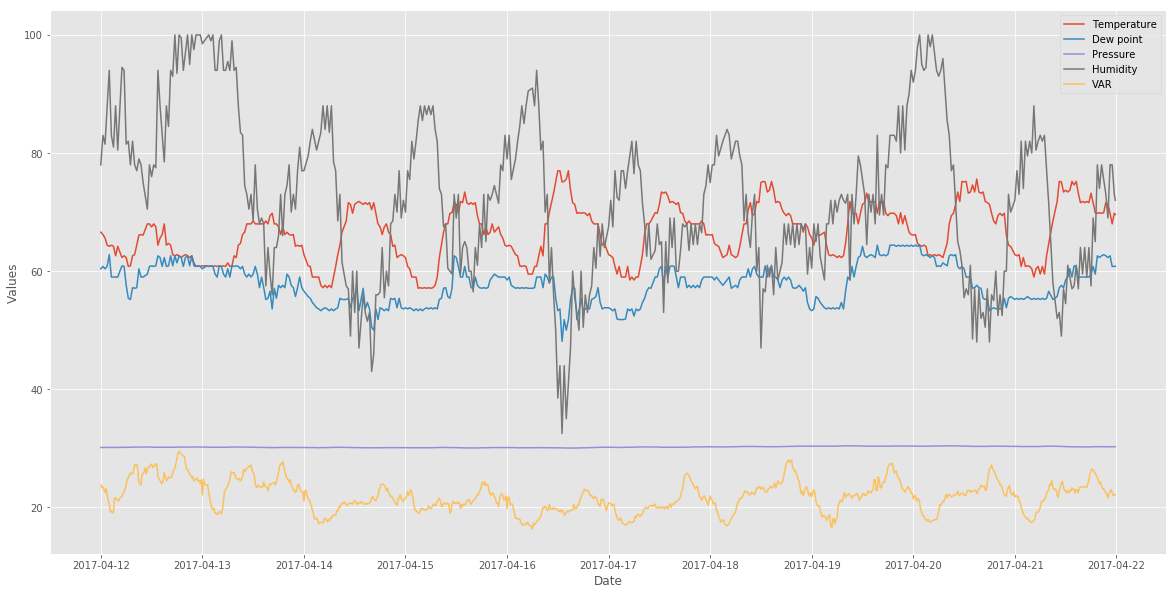

In [4]:
print(stats.spearmanr(df.humidity, df.VAR))

plt.figure(figsize=(20,10))
plt.plot(df.index, df.temperature, label='Temperature')
plt.plot(df.index, df.dew_point, label='Dew point')
plt.plot(df.index, df.pressure, label='Pressure')
plt.plot(df.index, df.humidity, label='Humidity')
plt.plot(df.index, df.VAR, label='VAR')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(loc='best')
plt.savefig('correlation.svg', format='svg', bbox_inches='tight')
plt.show()

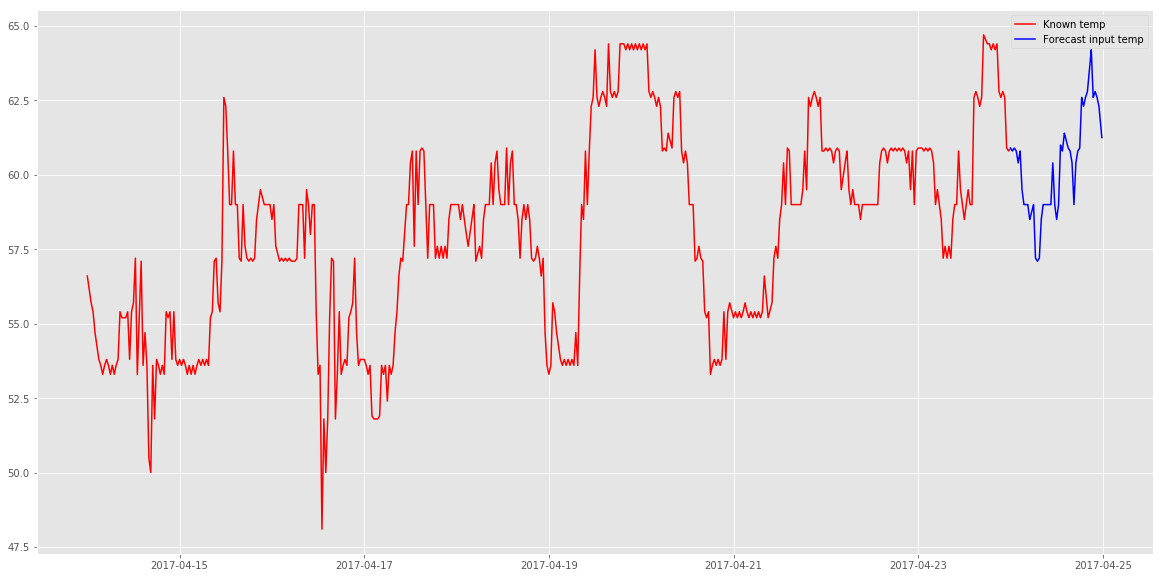

In [6]:
plt.figure(figsize=(20,10))
plt.plot(df_old.index, df_old.dew_point, color='red', label='Known temp')
plt.plot(forecast_dates, forecast_input.dew_point, color='blue', label='Forecast input temp')
plt.legend(loc='best')
plt.savefig('temp.svg', format='svg', bbox_inches='tight')
plt.show()

In [6]:
X = df.drop(columns=['VAR'])
#X = preprocessing.scale(X)

y = df.VAR

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(768, 4) (768,)
(192, 4) (192,)


In [8]:
svm_reg = svm.SVR(kernel='rbf')

#'C': [1, 1e2, 1e3, 5e3, 1e4]
#'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]

C = np.linspace(1, 1e4, 5)
gamma = np.linspace(1e-4, 1e-1, 6)

param_grid = {'C': [1, 5, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}

t = time()
svm_reg = GridSearchCV(svm_reg, param_grid, cv=3, n_jobs=-1)
svm_reg.fit(X_train, y_train)
print("Search time %0.2fs" % (time()-t), '\n')

with open('svr.pickle','wb') as f:
    pickle.dump(svm_reg, f)

print("Best estimator found by grid search:")
print(svm_reg.best_estimator_)

forecast_output = svm_reg.predict(forecast_input)

Search time 48.04s 

Best estimator found by grid search:
SVR(C=5000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [9]:
print('Train test scores')
pred = svm_reg.predict(X_test)

print("R^2 = %0.4f" % metrics.r2_score(y_test, pred))
print("MAE = %0.4f" % metrics.mean_absolute_error(y_test, pred))
print("RMSE = %0.4f" % np.sqrt(metrics.mean_squared_error(y_test, pred)))

print()

print('Unknown values scores')
known_forecast_output = svm_reg.predict(df_unknown.drop(columns=['VAR']))

print("R^2 = %0.4f" % metrics.r2_score(df_unknown.VAR, known_forecast_output))
print("MAE = %0.4f" % metrics.mean_absolute_error(df_unknown.VAR, known_forecast_output))
print("RMSE = %0.4f" % np.sqrt(metrics.mean_squared_error(df_unknown.VAR, known_forecast_output)))

Train test scores
R^2 = 0.5088
MAE = 1.4169
RMSE = 1.9084

Unknown values scores
R^2 = -3.0277
MAE = 3.4740
RMSE = 3.9626


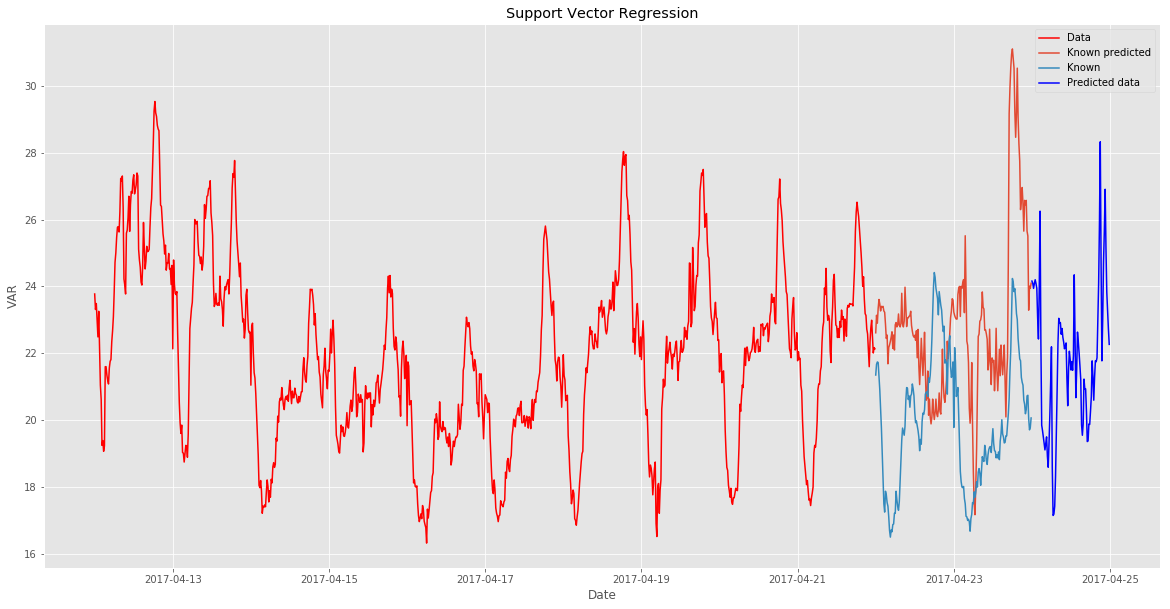

In [10]:
plt.figure(figsize=(20,10))

plt.plot(df.drop(columns=['VAR']).index, y, color='red', label='Data')
plt.plot(df_unknown.drop(columns=['VAR']).index, known_forecast_output, label='Known predicted')
plt.plot(df_unknown.drop(columns=['VAR']).index, df_unknown.VAR, label='Known')
#predicted_known_data = plt.plot(df.drop(columns=['VAR']).index, RF_reg.predict(X_train), color='green', label='Predicted known data')
plt.plot(forecast_dates, forecast_output, color='blue', label='Predicted data')

plt.title('Support Vector Regression')
plt.xlabel('Date')
plt.ylabel('VAR')
plt.legend(loc='best')
plt.savefig('svr.svg', format='svg', bbox_inches='tight')
plt.show()

In [11]:
rf_reg = RandomForestRegressor()

param_grid = {'n_estimators': [1, 50, 100, 500, 1000, 5000, 10000],
              'max_depth': [1, 2, 3, 4, 5],
              'criterion': ['mse', 'mae']}

t = time()
rf_reg = GridSearchCV(rf_reg, param_grid, cv=3, n_jobs=-1)
rf_reg.fit(X_train, y_train)
print("Search time %0.2fs" % (time()-t), '\n')

with open('rf_reg.pickle','wb') as f:
    pickle.dump(rf_reg, f)

print("Best estimator found by grid search:")
print(rf_reg.best_estimator_)

forecast_output = rf_reg.predict(forecast_input)

Search time 645.45s 

Best estimator found by grid search:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [12]:
pred2 = rf_reg.predict(X_test)

print("R^2 = %0.4f" % metrics.r2_score(y_test, pred2))
print("MAE = %0.4f" % metrics.mean_absolute_error(y_test, pred2))
print("RMSE = %0.4f" % np.sqrt(metrics.mean_squared_error(y_test, pred2)))

print()

print('Unknown values scores')
known_forecast_output = rf_reg.predict(df_unknown.drop(columns=['VAR']))

print("R^2 = %0.4f" % metrics.r2_score(df_unknown.VAR, known_forecast_output))
print("MAE = %0.4f" % metrics.mean_absolute_error(df_unknown.VAR, known_forecast_output))
print("RMSE = %0.4f" % np.sqrt(metrics.mean_squared_error(df_unknown.VAR, known_forecast_output)))

R^2 = 0.6940
MAE = 1.1859
RMSE = 1.5062

Unknown values scores
R^2 = -2.4190
MAE = 3.1440
RMSE = 3.6509


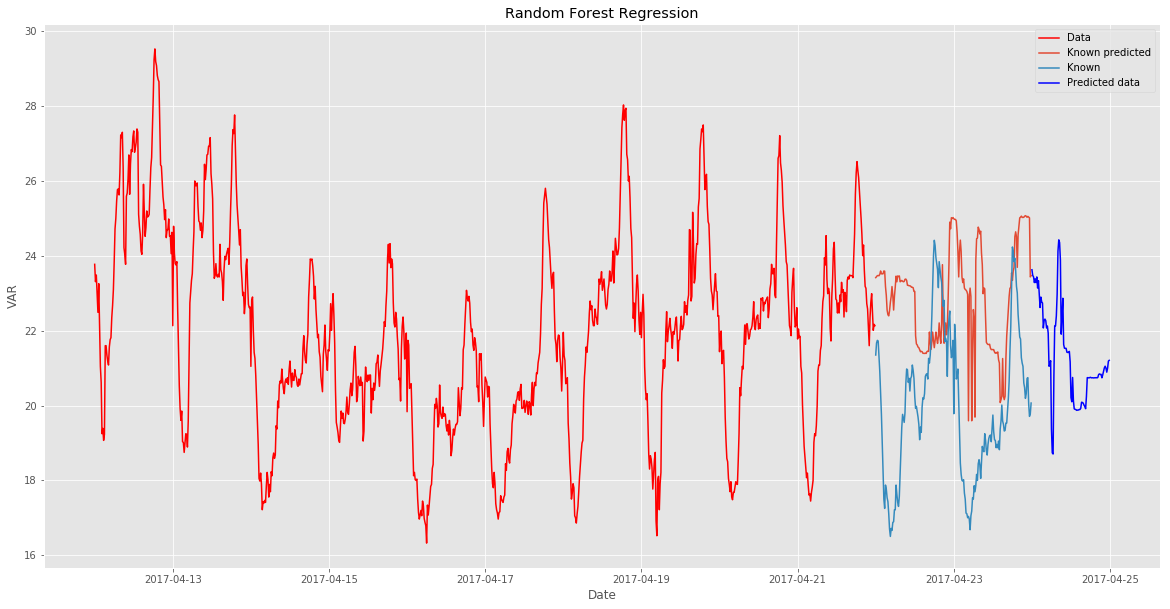

In [13]:
plt.figure(figsize=(20,10))

plt.plot(df.drop(columns=['VAR']).index, y, color='red', label='Data')
plt.plot(df_unknown.drop(columns=['VAR']).index, known_forecast_output, label='Known predicted')
plt.plot(df_unknown.drop(columns=['VAR']).index, df_unknown.VAR, label='Known')
#predicted_known_data = plt.plot(df.drop(columns=['VAR']).index, RF_reg.predict(X_train), color='green', label='Predicted known data')
plt.plot(forecast_dates, forecast_output, color='blue', label='Predicted data')

plt.title('Random Forest Regression')
plt.xlabel('Date')
plt.ylabel('VAR')
plt.legend(loc='best')
plt.savefig('rf.svg', format='svg', bbox_inches='tight')
plt.show()

In [18]:
kn_reg = KNeighborsRegressor()

param_grid = {'n_neighbors': [int(i) for i in np.linspace(1, 30, 30)],
              'leaf_size': [int(i) for i in np.linspace(1,100, 100)],
              'weights': ['uniform', 'distance']}

t = time()
kn_reg = GridSearchCV(kn_reg, param_grid, cv=3, n_jobs=-1)
kn_reg.fit(X_train, y_train)
print("Search time %0.2fs" % (time()-t), '\n')

with open('kn_reg.pickle','wb') as f:
    pickle.dump(kn_reg, f)

print("Best estimator found by grid search:")
print(kn_reg.best_estimator_)

forecast_output = kn_reg.predict(forecast_input)

Search time 44.28s 

Best estimator found by grid search:
KNeighborsRegressor(algorithm='auto', leaf_size=4, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=29, p=2,
          weights='distance')


In [19]:
pred3 = kn_reg.predict(X_test)

print("R^2 = %0.4f" % metrics.r2_score(y_test, pred3))
print("MAE = %0.4f" % metrics.mean_absolute_error(y_test, pred3))
print("RMSE = %0.4f" % np.sqrt(metrics.mean_squared_error(y_test, pred3)))

print()

print('Unknown values scores')
known_forecast_output = kn_reg.predict(df_unknown.drop(columns=['VAR']))

print("R^2 = %0.4f" % metrics.r2_score(df_unknown.VAR, known_forecast_output))
print("MAE = %0.4f" % metrics.mean_absolute_error(df_unknown.VAR, known_forecast_output))
print("RMSE = %0.4f" % np.sqrt(metrics.mean_squared_error(df_unknown.VAR, known_forecast_output)))

R^2 = 0.5314
MAE = 1.4387
RMSE = 1.8640

Unknown values scores
R^2 = -2.6257
MAE = 3.2959
RMSE = 3.7596


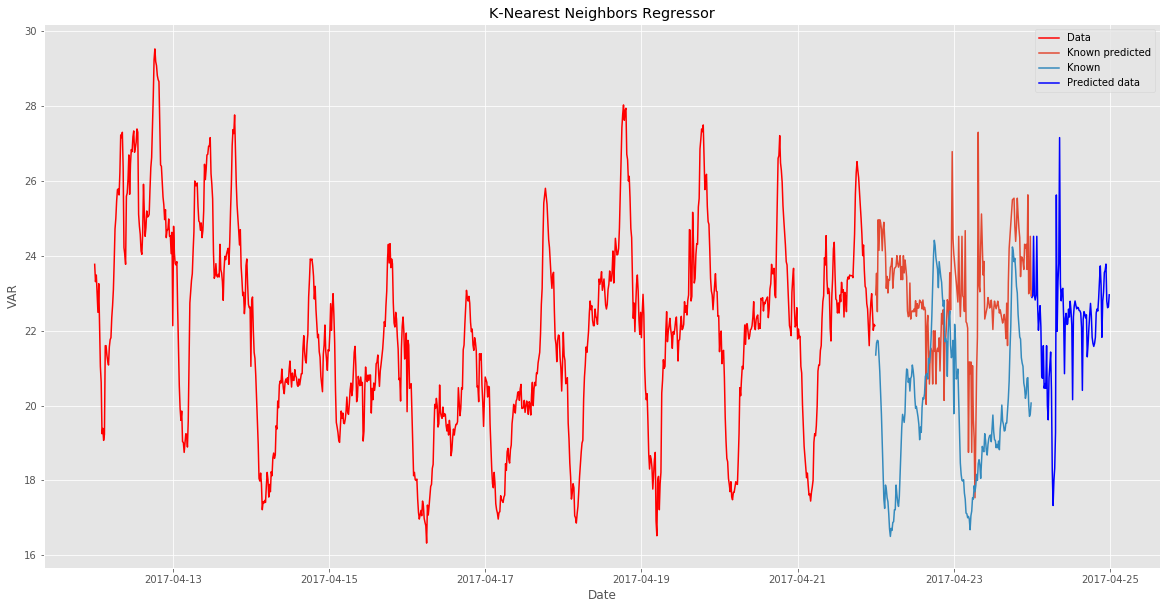

In [20]:
plt.figure(figsize=(20,10))

data = plt.plot(df.drop(columns=['VAR']).index, y, color='red', label='Data')
plt.plot(df_unknown.drop(columns=['VAR']).index, known_forecast_output, label='Known predicted')
plt.plot(df_unknown.drop(columns=['VAR']).index, df_unknown.VAR, label='Known')
#predicted_known_data = plt.plot(df.drop(columns=['VAR']).index, RF_reg.predict(X_train), color='green', label='Predicted known data')
predicted = plt.plot(forecast_dates, forecast_output, color='blue', label='Predicted data')

plt.title('K-Nearest Neighbors Regressor')
plt.xlabel('Date')
plt.ylabel('VAR')
plt.legend(loc='best')
plt.savefig('kn.svg', format='svg', bbox_inches='tight')
plt.show()


In [17]:
'''
forecast_output = np.round_(forecast_output, decimals=5)
df_copy.loc['2017-04-24':].iloc[:96].VAR = forecast_output

df_copy = df_copy.loc[:'2017-04-24']
df_copy
df_copy.to_csv('forecast_Dawid_Haniewicz.csv')
'''

"\nforecast_output = np.round_(forecast_output, decimals=5)\ndf_copy.loc['2017-04-24':].iloc[:96].VAR = forecast_output\n\ndf_copy = df_copy.loc[:'2017-04-24']\ndf_copy\ndf_copy.to_csv('forecast_Dawid_Haniewicz.csv')\n"